In [ ]:
import os
import numpy as np
import cv2
from PIL import Image

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras

import pandas as pd

In [ ]:
from google.colab import drive 

drive.mount('drive')


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
train_path = "drive/MyDrive/honor_cup/train/"


In [ ]:
hr_count = len(os.listdir(os.path.join(train_path, "HR")))
lr_count = len(os.listdir(os.path.join(train_path, "LR")))

print("The number of images is the same: {}".format(hr_count == lr_count))
print("The number of HR images: {}".format(hr_count))
print("The number of LR images: {}".format(lr_count))

for file in os.listdir(os.path.join(train_path, "LR")):
    if file not in os.listdir(os.path.join(train_path, "HR")):
        print("This file is not in HR data: {}".format(file))

The number of images is the same: False
The number of HR images: 346
The number of LR images: 347
This file is not in HR data: 43708c5a.png


In [ ]:
def preprocess(path, img_name):
    
#     img_input = cv2.imread(os.path.join(path, 'HR', img_name))
#     img_input = cv2.cvtColor(img_input, cv2.COLOR_BGR2RGB)
    
#     label = cv2.imread(os.path.join(path, 'LR', img_name))
#     label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)

    img_input = load_img(os.path.join(path, 'HR', img_name), target_size=(500,500))
    img_input = img_to_array(img_input)
    
    label = load_img(os.path.join(path, 'LR', img_name), target_size=(250,250))
    label = img_to_array(label)
    
    
    #Normalized
    img_input = img_input / 255.
    label = label / 255.
    
    return img_input, label

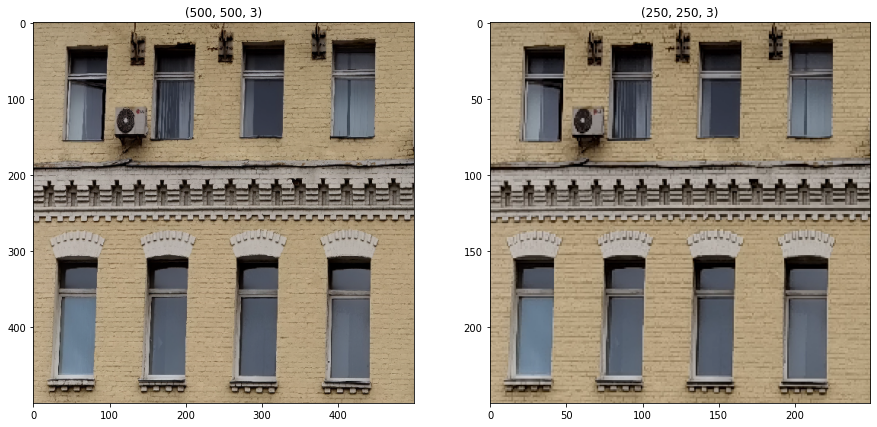

In [ ]:
img_name = "0b2f6564.png"
img_input, label = preprocess(train_path, img_name)

plt.figure(figsize=(15,15))
for i, img in enumerate([img_input,label]):
    plt.subplot(1,2,i+1)
    plt.title("{}".format(img.shape))
    plt.imshow(img)

In [ ]:
# hr_shapes = {}
# lr_shapes = {}
# for img_name in os.listdir(os.path.join(train_path, "HR")):
#     img_input, label = preprocess(train_path, img_name)
    
#     count = hr_shapes.get(img_input.shape, 0)
#     hr_shapes[img_input.shape] = count + 1
    
#     count = lr_shapes.get(label.shape, 0)
#     lr_shapes[label.shape] = count + 1
        
# print("HR shapes: {}".format(hr_shapes))
# print("LR shapes: {}".format(lr_shapes))

In [ ]:
inputs = []
labels = []

for img_name in os.listdir(os.path.join(train_path, "HR")):
    img_input, label = preprocess(train_path, img_name)
    
    inputs.append(img_input)
    labels.append(label)
    
inputs = np.asarray(inputs).astype('float32')
labels = np.asarray(labels).astype('float32')

In [ ]:
labels.shape

(346, 250, 250, 3)

In [ ]:
def get_model(upscale_factor=2, channels=3):
    conv_args = {
            "activation": "relu",
            "kernel_initializer": "Orthogonal",
            "padding": "same",
        }
    inputs = Input(shape=(None, None, channels))
    x = Conv2D(64, 5, **conv_args)(inputs)
    x = Conv2D(32, 3, (2,2), **conv_args)(x)
    x = Conv2D(channels * (upscale_factor ** 2), 3, (2,2), **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return Model(inputs, outputs)

In [ ]:
model = get_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d (Conv2D)              (None, None, None, 64)    4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 12)    3468      
_________________________________________________________________
tf_op_layer_DepthToSpace (Te [(None, None, None, 3)]   0         
Total params: 26,796
Trainable params: 26,796
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)


filepath="model.h5"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)


callbacks = [early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

epochs = 30

model.compile(
    optimizer=optimizer, loss=loss_fn,
)


In [ ]:
model.fit(
    inputs, labels, batch_size=32, epochs=epochs, callbacks=callbacks, verbose=0
)

# The model weights (that are considered the best) are loaded into the model.
# model.load_weights(checkpoint_filepath)

In [ ]:
test_path = "drive/MyDrive/honor_cup/test/HR"
filename = os.listdir(test_path)[0]
img = load_img(os.path.join(test_path, filename), target_size=(500,500))

img2 = load_img(os.path.join(test_path, filename), target_size=(250,250))

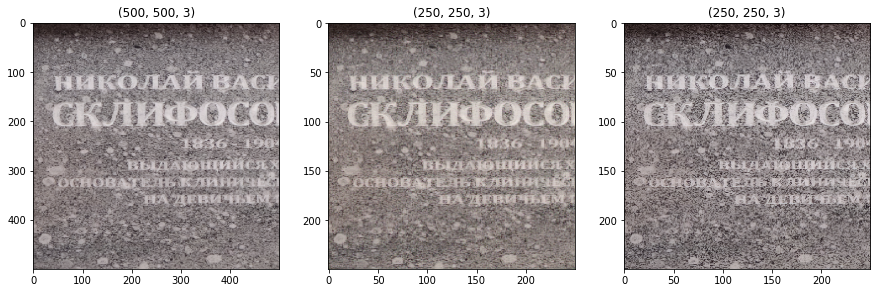

In [ ]:
img = img_to_array(img)
prediction = model.predict(img.reshape((1, 500, 500, 3)))
prediction = prediction.reshape((250, 250, 3)).astype('int')
img = img.astype('int')

img2 = img_to_array(img2)
img2 = img2.astype('int')


plt.figure(figsize=(15,15))
for i, im in enumerate([img,prediction, img2]):
    plt.subplot(1,3,i+1)
    plt.title("{}".format(im.shape))
    plt.imshow(im)